In [1]:
import sys
sys.path.append('../')
from src.data import SegmentationDataMapOSM
from nuscenes.nuscenes import NuScenes
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
from pyquaternion import Quaternion
import numpy as np
from src.tools import get_local_map
import cv2

### Parameters

In [2]:
version='mini'
dataroot='/home/ruslan/datasets/nuscenes'
osm_path='../../monolayout/data/osm/'
gpuid = 0

H=900
W=1600
final_dim=(256, 704)  # (128, 352)
resize_lim = (0.386, 0.450)  # (0.193, 0.225)
bot_pct_lim=(0.0, 0.22)
rot_lim=(-5.4, 5.4)
rand_flip=False
ncams=1

max_grad_norm=5.0
pos_weight=2.13

xbound=[0.0, 32.0, 0.25]
ybound=[-16.0, 16.0, 0.25]
zbound=[-10.0, 10.0, 20.0]
dbound=[4.0, 45.0, 1.0]


grid_conf = {
    'xbound': xbound,
    'ybound': ybound,
    'zbound': zbound,
    'dbound': dbound,
}

# cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
#         'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
cams = ['CAM_FRONT']

data_aug_conf = {
                'resize_lim': resize_lim,
                'final_dim': final_dim,
                'rot_lim': rot_lim,
                'H': H, 'W': W,
                'rand_flip': rand_flip,
                'bot_pct_lim': bot_pct_lim,
                'cams': cams,
                'Ncams': ncams,
                }


### Load data

In [3]:
from src.tools import get_nusc_maps

nusc = NuScenes(version='v1.0-{}'.format(version),
                dataroot=dataroot,
                verbose=False)

map_folder = dataroot
nusc_maps = get_nusc_maps(map_folder)

valdata = SegmentationDataMapOSM(osm_path,
                                 nusc_maps,
                                 nusc,
                                 is_train=False,
                                 data_aug_conf=data_aug_conf,
                                 grid_conf=grid_conf)
traindata = SegmentationDataMapOSM(osm_path,
                                   nusc_maps,
                                   nusc,
                                   is_train=True,
                                   data_aug_conf=data_aug_conf,
                                   grid_conf=grid_conf)

NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.386, 0.45), 'final_dim': (256, 704), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT'], 'Ncams': 1}
NuscData: 323 samples. Split: train.
                   Augmentation Conf: {'resize_lim': (0.386, 0.45), 'final_dim': (256, 704), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': False, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT'], 'Ncams': 1}


### Explore data

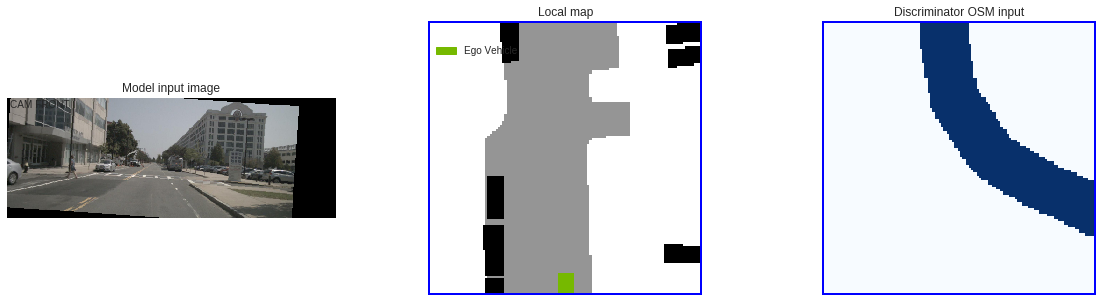

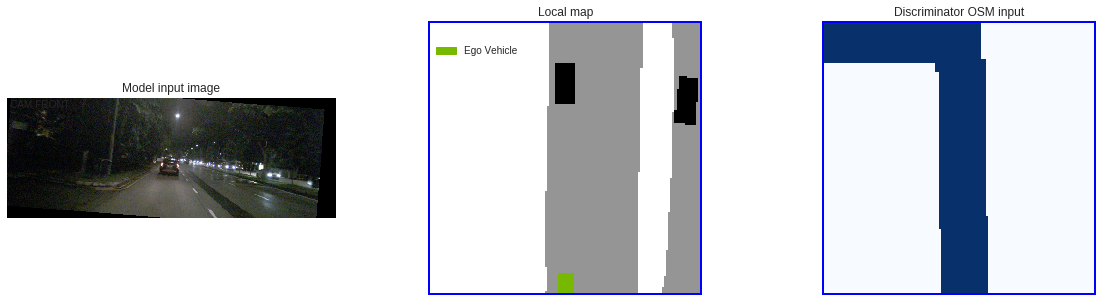

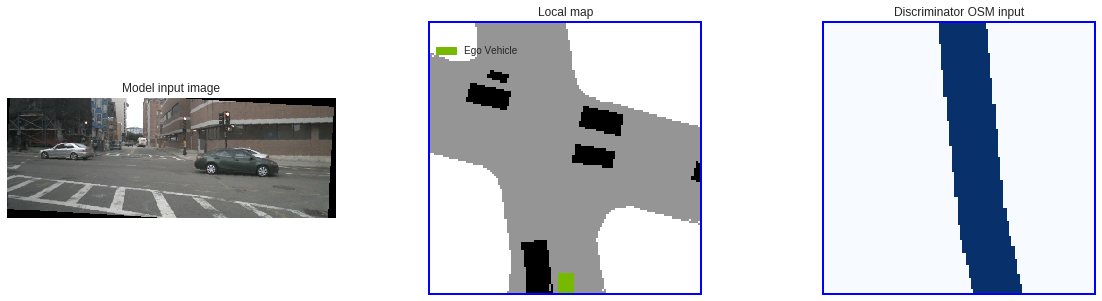

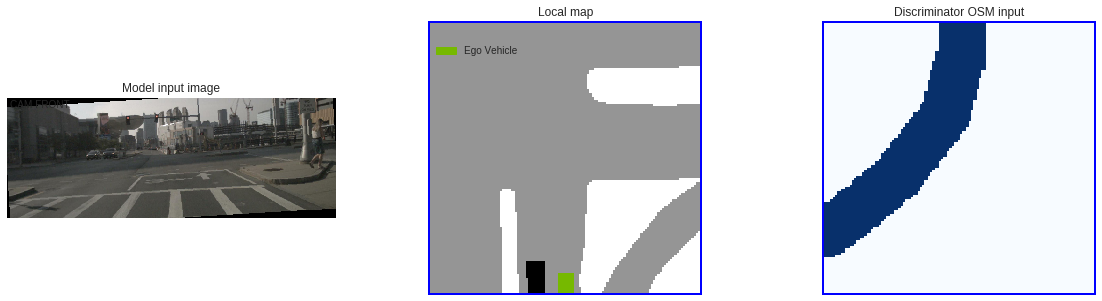

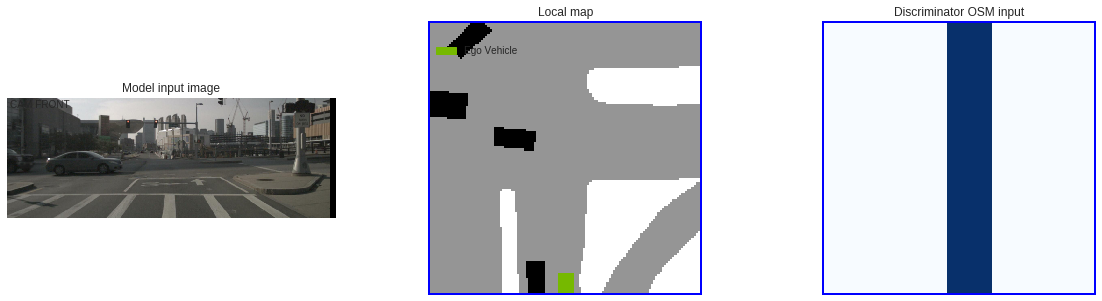

In [4]:
from src.tools import (ego_to_cam, get_only_in_img_mask, denormalize_img,
                    SimpleLoss, get_val_info, add_ego, gen_dx_bx,
                    get_nusc_maps, plot_nusc_map)
from PIL import Image
import matplotlib.patches as mpatches
%matplotlib inline

dx, bx, _ = gen_dx_bx(grid_conf['xbound'], grid_conf['ybound'], grid_conf['zbound'])
dx, bx = dx[:2].numpy(), bx[:2].numpy()

data = traindata

for counter in np.random.choice(range(len(data)), 5):
    imgs, rots, trans, intrins, post_rots, post_trans, map_binimg, discr_input = data[counter]

    fig = plt.figure(figsize=(20, 5))

    plt.clf()
    # model input image
    ax = plt.subplot(1, 3, 1)
    plt.title('Model input image')
    for imgi, img in enumerate(imgs):
        showimg = denormalize_img(img)
        plt.imshow(showimg)
        plt.axis('off')
        plt.annotate(cams[imgi].replace('_', ' '), (0.01, 0.92), xycoords='axes fraction')

    # local map
    ax = plt.subplot(1, 3, 2)
    plt.title('Local map')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.setp(ax.spines.values(), color='b', linewidth=2)
    plt.legend(handles=[
        mpatches.Patch(color='#76b900', label='Ego Vehicle'),
    ], loc=(0.01, 0.86))

    # plot local map
    drivable_area = map_binimg[0, ...]
    cars = map_binimg[1, ...]
    local_map = drivable_area.detach().clone()
    local_map[cars.bool()] = 2.
    plt.imshow(local_map.squeeze(0))
    # camera FOV
#     fov_x, fov_y = fov_from_intrinsics(intrins.squeeze().cpu().numpy(), H, W)
#     R_lookup = data.nx[0]
#     plt.arrow(data.nx[0]/2., 0, R_lookup*np.sin(fov_y/2.), R_lookup*np.cos(fov_y/2.))
#     plt.arrow(data.nx[0]/2., 0, R_lookup*np.sin(-fov_y/2.), R_lookup*np.cos(-fov_y/2.))
    
    plt.xlim((data.nx[0], 0))
    plt.ylim((0, data.nx[1]))
    add_ego(bx, dx)
    
    # discriminator input
    ax = plt.subplot(1, 3, 3)
    plt.title('Discriminator OSM input')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.setp(ax.spines.values(), color='b', linewidth=2)
    plt.imshow(discr_input[0], cmap='Blues')
    plt.xlim((data.nx[0], 0))
    plt.ylim((0, data.nx[1]))

    plt.show()

### Training with Discriminator

In [5]:
import torch
from time import time
from tensorboardX import SummaryWriter
import numpy as np
import os
from tqdm import tqdm

from src.models import compile_model
from src.models import Discriminator
from src.tools import SimpleLoss, get_batch_iou, get_val_info

In [6]:
bsz=6
nworkers=10
lr=1e-3
weight_decay=1e-7
nepochs = 20

logdir = f'../runs/lss_{time()}'
writer = SummaryWriter(logdir=logdir)

In [7]:
def worker_rnd_init(x):
    np.random.seed(13 + x)
    
trainloader = torch.utils.data.DataLoader(traindata, batch_size=bsz,
                                          shuffle=True,
                                          num_workers=nworkers,
                                          drop_last=True,
                                          worker_init_fn=worker_rnd_init)
valloader = torch.utils.data.DataLoader(valdata, batch_size=1,
                                        shuffle=False,
                                        num_workers=nworkers)

Compile LSS model

In [8]:
device = torch.device('cpu') if gpuid < 0 else torch.device(f'cuda:{gpuid}')

model = compile_model(grid_conf, data_aug_conf, outC=2)
model.to(device)

model_optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_fn = SimpleLoss(pos_weight).cuda(gpuid)

model.train();

Loaded pretrained weights for efficientnet-b0


In [9]:
from torch.autograd import Variable
import torch.nn as nn

discriminators = {}
discriminators['static'] = Discriminator()
discriminators['dynamic'] = Discriminator()

for key in discriminators.keys():
    discriminators[key].to(device)
    discriminators[key].train()

optimizers_D = {}
optimizers_D['static'] = torch.optim.Adam(discriminators['static'].parameters(), lr=0.001)
optimizers_D['dynamic'] = torch.optim.Adam(discriminators['dynamic'].parameters(), lr=0.001)

weights_D = {}
weights_D['static'] = 0.2
weights_D['dynamic'] = 0.8

lambda_D = 0.01
occ_map_size = int((grid_conf['xbound'][1] - grid_conf['xbound'][0]) / grid_conf['xbound'][2])
patch = (1, occ_map_size // 2 ** 4, occ_map_size // 2 ** 4)

epoch_to_start_train_disc = 0

valid = Variable(torch.Tensor( np.ones((bsz, *patch)) ),
                 requires_grad=False).float().cuda()
fake = Variable(torch.Tensor( np.ones((bsz, *patch)) ),
                requires_grad=False).float().cuda()

criterion_d = nn.BCEWithLogitsLoss()

In [10]:
counter = 0

max_val_iou = 0.0

# for epoch in tqdm(range(nepochs)):
for epoch in tqdm(range(5)):
    np.random.seed()
    for batchi, (imgs, rots, trans, intrins, post_rots, post_trans, binimgs, discr_input) in enumerate(trainloader):
        t0 = time()
        
        model_optimizer.zero_grad()
        preds = model(imgs.to(device),
                rots.to(device),
                trans.to(device),
                intrins.to(device),
                post_rots.to(device),
                post_trans.to(device),
                )
        binimgs = binimgs.to(device)
        static_discr_input = discr_input[:,0,:,:].unsqueeze(1).to(device)
        dynamic_discr_input = discr_input[:,1,:,:].unsqueeze(1).to(device)
        
        loss = loss_fn(preds, binimgs)
        
        fake_pred_static = discriminators['static'](preds[:,0,:,:].unsqueeze(1))
        real_pred_static = discriminators['static'](static_discr_input)
        
        fake_pred_dynamic = discriminators['dynamic'](preds[:,1,:,:].unsqueeze(1))
        real_pred_dynamic = discriminators['dynamic'](dynamic_discr_input)
        
        loss_GAN = weights_D['static']*criterion_d(fake_pred_static, valid) + \
                   weights_D['dynamic']*criterion_d(fake_pred_dynamic, valid)
        
        loss_D_static = weights_D['static']*( criterion_d(fake_pred_static, fake) + \
                                              criterion_d(real_pred_static, valid) )
        loss_D_dynamic = weights_D['dynamic']*( criterion_d(fake_pred_dynamic, fake) + \
                                                criterion_d(real_pred_dynamic, valid) )
        
        loss_D = loss_D_static + loss_D_dynamic
        loss_G = lambda_D * loss_GAN + loss
                        
        if epoch > epoch_to_start_train_disc:
            loss_G.backward(retain_graph=True)
            optimizers_D['static'].zero_grad()
            loss_D.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            model_optimizer.step()
            optimizers_D['static'].step()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            model_optimizer.step()
        
        counter += 1
        
        t1 = time()
        
        if counter % 10 == 0:
            writer.add_scalar('train/loss', loss, counter)
            writer.add_scalar('discriminator/loss', loss_D, counter)
            writer.add_scalar('discriminator/loss_static', loss_D_static, counter)
            writer.add_scalar('discriminator/loss_dynamic', loss_D_dynamic, counter)

        if counter % 50 == 0:
            _, _, iou = get_batch_iou(preds, binimgs)
            writer.add_scalar('train/iou', iou, counter)
            writer.add_scalar('train/epoch', epoch, counter)
            writer.add_scalar('train/step_time', t1 - t0, counter)

        if counter % 50 == 0:
            val_info = get_val_info(model, valloader, loss_fn, device)
            print('VAL', val_info)
            writer.add_scalar('val/loss', val_info['loss'], counter)
            writer.add_scalar('val/iou', val_info['iou'], counter)
            writer.add_scalar('val/iou_static', val_info['iou_static'], counter)
            writer.add_scalar('val/iou_dynamic', val_info['iou_dynamic'], counter)

            if val_info['iou'] > max_val_iou:
                max_val_iou = val_info['iou']
                model.eval()
                mname = os.path.join(logdir, "model_iou_{}.pt".format(val_info['iou']))
                print('saving', mname)
                torch.save(model.state_dict(), mname)
                model.train()

  0%|          | 0/5 [00:00<?, ?it/s]

0.9545764923095703 0.4784092903137207 0.9755362272262573
0.9554711580276489 0.47770175337791443 1.1134452819824219
0.9548782706260681 0.4769577383995056 0.9724725484848022
0.957513153553009 0.4798741936683655 0.8661394119262695
0.9551941156387329 0.47751691937446594 0.8826534748077393
0.9530249238014221 0.47762560844421387 0.8599047660827637
0.9538301229476929 0.47717583179473877 0.8010144233703613
0.953950047492981 0.4776216149330139 0.7709020376205444
0.9555759429931641 0.47714707255363464 0.7450112104415894
0.9574136734008789 0.47811394929885864 0.735962986946106
0.9542871713638306 0.47813960909843445 0.694629430770874
0.9544385075569153 0.47741639614105225 0.6387069225311279
0.9538858532905579 0.4764876961708069 0.597970724105835
0.9539116621017456 0.4761311113834381 0.5897404551506042
0.9535764455795288 0.4762324094772339 0.6202229261398315
0.9547217488288879 0.47694385051727295 0.7013231515884399
0.9543668031692505 0.47691771388053894 0.6307200193405151
0.9552736878395081 0.47673

 20%|██        | 1/5 [00:23<01:32, 23.20s/it]

0.9551002383232117 0.4776650369167328 0.4471604824066162
0.9521598219871521 0.47621023654937744 0.406863808631897
0.9532877206802368 0.4766935110092163 0.43835100531578064
0.9508857727050781 0.475715696811676 0.3566688895225525
0.9519314765930176 0.474587082862854 0.47887271642684937
0.9489202499389648 0.47398683428764343 0.34161707758903503
0.9472922086715698 0.47330957651138306 0.3601834774017334
0.9467219710350037 0.4722197949886322 0.49206531047821045
0.9457923769950867 0.4721084535121918 0.4382568597793579
0.9403268098831177 0.47095978260040283 0.37978658080101013
0.9425860643386841 0.47018754482269287 0.3718078136444092
0.9407489895820618 0.46954280138015747 0.442263662815094
0.9394334554672241 0.46947094798088074 0.45775601267814636
0.939336359500885 0.46886131167411804 0.4215492606163025
0.9379380345344543 0.46837061643600464 0.4064757823944092
0.9376792907714844 0.46657347679138184 0.3506436347961426
0.9351285696029663 0.46627891063690186 0.388367623090744
0.9342383742332458 0

 40%|████      | 2/5 [00:56<01:18, 26.17s/it]

0.9106565713882446 0.4537673890590668 0.4131702184677124
0.909640908241272 0.4529394209384918 0.35727161169052124
0.9108682870864868 0.45318129658699036 0.5211802124977112
0.9082412123680115 0.4533257484436035 0.37689098715782166
0.909186065196991 0.4530288875102997 0.2895437180995941
0.9050353765487671 0.4513261318206787 0.2994656562805176
0.9080240726470947 0.45299991965293884 0.4251880645751953
0.9075794219970703 0.45248517394065857 0.4257030487060547
0.9058405160903931 0.4513404369354248 0.4272850453853607
0.9071418046951294 0.45202213525772095 0.3715798556804657
0.9055719375610352 0.45084884762763977 0.2834071218967438
0.9069994688034058 0.45111823081970215 0.3445972800254822
0.904173731803894 0.45001667737960815 0.2823490798473358
0.9030278921127319 0.4506053626537323 0.3906240463256836
0.9051564931869507 0.4517442286014557 0.44189453125
0.9044817090034485 0.44988811016082764 0.3027864694595337
0.9042961597442627 0.45024240016937256 0.4257621467113495
0.9007705450057983 0.4492149

 60%|██████    | 3/5 [01:29<00:56, 28.32s/it]

0.8949681520462036 0.44565069675445557 0.31837135553359985
0.8922727704048157 0.4448273181915283 0.3494754731655121
0.8940750956535339 0.4444535970687866 0.30271464586257935
0.8932176828384399 0.4444780647754669 0.26565712690353394
0.8926253914833069 0.44546717405319214 0.4445797801017761
0.8948749899864197 0.4441777467727661 0.3791393041610718
0.892196536064148 0.4444611668586731 0.3510909974575043
0.8930500149726868 0.44413700699806213 0.27753302454948425
0.8943541646003723 0.4445941150188446 0.34014344215393066
0.8912060260772705 0.4433819055557251 0.27050352096557617
0.8923332691192627 0.4438911974430084 0.3212391138076782
0.891799807548523 0.44274789094924927 0.28289663791656494
0.888875424861908 0.4430616497993469 0.3390636444091797
0.8924287557601929 0.443704217672348 0.3727712631225586
0.893183708190918 0.4438793659210205 0.26049742102622986
0.8929091691970825 0.4439204931259155 0.35608696937561035
0.892839252948761 0.44410964846611023 0.3147367238998413
0.8917364478111267 0.44

 80%|████████  | 4/5 [02:04<00:30, 30.15s/it]

0.8887945413589478 0.4424414336681366 0.2996940016746521
0.8902572989463806 0.44228625297546387 0.29695260524749756
0.888157069683075 0.44196242094039917 0.3086704909801483
0.8890891671180725 0.44224295020103455 0.2987375855445862
0.8888934254646301 0.44216418266296387 0.33909010887145996
0.8877594470977783 0.44130662083625793 0.26558470726013184
0.8893061280250549 0.442110151052475 0.29186010360717773
0.8893863558769226 0.44108647108078003 0.33594298362731934
0.8893570899963379 0.44143974781036377 0.2508193254470825
0.8882436752319336 0.4413565993309021 0.33225956559181213
0.8877289295196533 0.4412229061126709 0.23019251227378845
0.8886456489562988 0.4416991174221039 0.3297942578792572
0.8885335922241211 0.44164013862609863 0.4412316679954529
0.8878852725028992 0.4417872428894043 0.43543872237205505
0.887901246547699 0.44104743003845215 0.25441986322402954
0.8884141445159912 0.4404841661453247 0.3132084608078003
0.8869427442550659 0.44083908200263977 0.3706694543361664
0.8871399164199

100%|██████████| 5/5 [02:37<00:00, 31.54s/it]
